In [20]:
import torch
import json
import os


configs = {
    "train_source_data":"/content/train.en",
    "train_target_data":"/content/train.de",
    "valid_source_data":"/content/val.en",
    "valid_target_data":"/content/val.de",
    "source_tokenizer":"bert-base-uncased",
    "target_tokenizer":"dbmdz/bert-base-german-cased",
    "source_max_seq_len":256,
    "target_max_seq_len":256,
    "batch_size":40,
    "device":"cuda:0" if torch.cuda.is_available() else "cpu",
    "embedding_dim": 512,
    "n_layers": 6,
    "n_heads": 8,
    "dropout": 0.25,
    "lr":0.000001,
    "n_epochs":30,
    "print_freq": 5,
    "beam_size":3,
    "model_path":"/content/model_transformer_translate_en_vi.pt",
    "early_stopping":5
}

import matplotlib.pyplot as plt

# visualize log
def plot_loss(log_path, log_dir):
    log = json.load(open(log_path, "r"))

    plt.figure()
    plt.plot(log["train_loss"], label="train loss")
    plt.plot(log["valid_loss"], label="valid loss")
    plt.title("Loss per epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(os.path.join(log_dir, "loss_epoch.png"))

    # plot batch loss
    plt.figure()
    lst = log["train_batch_loss"]
    n = int(len(log["train_batch_loss"]) / len(log["valid_batch_loss"]))
    train_batch_loss = [lst[i:i + n][0] for i in range(0, len(lst), n)]
    plt.plot(train_batch_loss, label="train loss")
    plt.plot(log["valid_batch_loss"], label="valid loss")
    plt.title("Loss per batch")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(os.path.join(log_dir, "loss_batch.png"))



In [2]:
pip install -U SoMaJo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 3.7 MB/s eta 0:00:00


In [3]:
import torch
import numpy as np
from torch.utils.data import Dataset
from transformers import AutoTokenizer
from tqdm import tqdm
import re
import io
from collections import Counter
from torchtext.data.functional import generate_sp_model, load_sp_model, sentencepiece_tokenizer, sentencepiece_numericalizer
from torchtext.data.functional import numericalize_tokens_from_iterator
import sentencepiece as spm
import pandas as pd
from collections import defaultdict
from pathlib import Path
from torchtext.vocab import vocab
from somajo import SoMaJo


class TrainTranslateDataset(Dataset):
    def __init__(self, source_data=None, target_data=None, source_max_seq_len=256, target_max_seq_len=256, phase="train"):
        self.source_data = source_data
        self.target_data = target_data
        #self.source_tokenizer = source_tokenizer
        #self.target_tokenizer = target_tokenizer
        self.source_max_seq_len = source_max_seq_len
        self.target_max_seq_len = target_max_seq_len
        self.phase = phase
        #self.vocab_dict=vocab_dict
        #self.new_dict=new_dict

        source_path='/content/train.en'
        target_path='/content/train.de'
        source_data = open(source_path).read()
        target_data= open(target_path).read()
        srce_file_path = "eng_traintext_file.txt"
        targ_file_path= "german_traintext_file.txt"
        with open(srce_file_path, "w") as file:
         # 문자열들을 파일에 쓰기
          file.writelines(source_data)

        with open(targ_file_path, "w") as file:
         # 문자열들을 파일에 쓰기
          file.writelines(target_data)




        def preprocess_seq(seq):
          seq = re.sub(r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’\!;]", " ", str(seq))
          seq = re.sub(r"[ ]+", " ", seq)
          seq = re.sub(r"\!+", "!", seq)
          seq = re.sub(r"\,+", ",", seq)
          seq = re.sub(r"\?+", "?", seq)
          seq = re.sub(r"[^\w\s]", "", seq)
          seq = re.sub(r"\d+", "",seq)
          seq = re.sub(r" ", "\u2581", seq)
          seq = seq.lower()
          return seq

        def targ_preprocess_seq(seq):
          seq = re.sub(r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’\!;]", " ", str(seq))
          seq = re.sub(r"[ ]+", " ", seq)
          seq = re.sub(r"\!+", "!", seq)
          seq = re.sub(r"\,+", ",", seq)
          seq = re.sub(r"\?+", "?", seq)
          seq = re.sub(r"[^\w\s]", "", seq)
          seq = re.sub(r"\d+", "",seq)
          seq = seq.lower()
          return seq

        #source,target 토크나이징
        self.source= spm.SentencePieceTrainer.train('--input=eng_traintext_file.txt  --model_prefix=wmt2016en --vocab_size=28000 --model_type=bpe --max_sentence_length=500')
        sp = spm.SentencePieceProcessor()
        sp.Load('wmt2016en.model')
        target_tokenizer = SoMaJo("de_CMC", split_camel_case=True, xml_sentences="s")


       # print("source is : "+ source_data[10:100])

        #source array
        with open(srce_file_path, "r") as file:
         self.source_array=[]
         for i in range(29000):
          source_line=file.readline()
          source_result=preprocess_seq(source_line)
          self.source_tokens=sp.EncodeAsPieces(source_result)
          self.source_array.append(self.source_tokens)

        #target array
        with open(targ_file_path, "r") as file:
         self.target_array=[]
         for i in range(29000):
          target_line=file.readline()
          target_result=targ_preprocess_seq(target_line)
          #print([target_result])
          sentences = target_tokenizer.tokenize_text([target_result])
          for sentence in sentences:
             sentence_tokens = [token.text for token in sentence]
             self.target_array.append(sentence_tokens)
         #print(self.target_array)



        #source dict로 변환
        self.source_vocab_dict = {}
        self.source_new_dict={}
        with open("wmt2016en.vocab", "r", encoding="utf-8") as f:
            for line in f:
              source_word, source_index = line.strip().split('\t')  # 탭 문자로 분리
              self.source_vocab_dict[source_word] = int(source_index)
              self.source_new_dict = {key:abs(value)+3 for key, value in self.source_vocab_dict.items()}
              self.source_new_dict[0] = '<PAD>'
              self.source_new_dict['<unk>']= 0
              self.source_new_dict['<s>']= 1
              self.source_new_dict['</s>']= 2

        print(self.source_new_dict)


        def frequency_of_vocab(data):
          flattened_list = [item for sublist in data for item in sublist]

          element_count = Counter(flattened_list)
          element_count_dict = dict(element_count)


          #words = ' '.join(data)
          #list로 변
          #words = words.split(data)

         #몇번 반복되는지 확인해주는 counter
         #counter = Counter(data)
         #print(len(counter))
         #오름차순으로 정렬
          vocab = sorted(element_count_dict, key=element_count_dict.get, reverse=True)
         #1위부터 매핑
          int2word = dict(enumerate(vocab, 1))
         #순서반대
          int2word[0] = ''
          self.word2int = {word: id for id, word in int2word.items()}
          print(len(self.word2int))
          return self.word2int


        def longlist(source_enc):
          length=max(len(elem)for elem in source_enc)
          return length


        self.target_new_dict=frequency_of_vocab(self.target_array)
        print(self.target_new_dict)

        self.source_enc=[[self.source_new_dict[value] for value in eng] for eng in tqdm(self.source_array)]
        self.target_enc=[[self.target_new_dict[value] for value in eng] for eng in tqdm(self.target_array)]

        def pad_features(sources, pad_id, seq_length):

          features = np.full((len(sources), seq_length), pad_id, dtype=int)

          for i, row in enumerate(sources):
          # if seq_length < len(row) then review will be trimmed
          #print(i,len(row))

            features[i, :len(row)] = np.array(row)[:seq_length]
          #print(features[0])

          return features

        seq_length = 64

        #으로 채워주자
        self.source_features = pad_features(self.source_enc, pad_id=0, seq_length=seq_length)
        self.target_features = pad_features(self.target_enc, pad_id=0, seq_length=seq_length)
        #print(target_features[0:2])



    def __len__(self):
        return len(self.source_data)

    # create decoder input mask
    def create_decoder_mask(self, seq_len):
        mask = torch.ones(seq_len, seq_len).tril()
        return mask

    def __getitem__(self, index):
        # source_seq, source_idx = self.convert_line_uncased(
        #     tokenizer=self.source_tokenizer,
        #     text=self.preprocess_seq(self.source_data[index]),
        #     max_seq_len=self.source_max_seq_len
        # )
        # target_seq, target_idx = self.convert_line_uncased(
        #     tokenizer=self.target_tokenizer,
        #     text=self.preprocess_seq(self.target_data[index]),
        #     max_seq_len=self.target_max_seq_len
        # )


        source=pd.DataFrame({"input_ids":self.source_features[index]})
        source=source["input_ids"].tolist()
        source = torch.tensor(source)

        target=pd.DataFrame({"input_ids":self.target_features[index]})
        target=target["input_ids"].tolist()
        target = torch.tensor(target)

        return {
                "source_seq": self.source_data[index],
                "source_ids": source,
                "target_seq": self.target_data[index],
                "target_ids": target,
                }
        #else:
            #return {
               # "source_seq": self.source_data[index],
               # "source_ids": source["input_ids"][0],
           # }


def main():

    def read_data(source_file, target_file):
        source_data = open(source_file).read().strip().split("\n")
        target_data = open(target_file).read().strip().split("\n")
        return source_data, target_data

    train_src_data, train_trg_data = read_data(configs["train_source_data"], configs["train_target_data"])
    valid_src_data, valid_trg_data = read_data(configs["valid_source_data"], configs["valid_target_data"])

    #source_tokenizer = AutoTokenizer.from_pretrained(configs["source_tokenizer"])
    #target_tokenizer = AutoTokenizer.from_pretrained(configs["target_tokenizer"])
    train_dataset = TrainTranslateDataset(
        #source_tokenizer=source_tokenizer,
        #target_tokenizer=target_tokenizer,
        source_data=train_src_data,
        target_data=train_trg_data,
        source_max_seq_len=configs["source_max_seq_len"],
        target_max_seq_len=configs["target_max_seq_len"]
    )


    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=configs["batch_size"],
        shuffle=True
    )

    for batch in train_loader:
        print(batch["source_seq"])
        print(batch["target_seq"])
        print(batch["source_ids"])
        print(batch["target_ids"])
        break




if __name__ == "__main__":
    main()

{'<unk>': 0, '<s>': 1, '</s>': 2, '▁a': 3, 'in': 4, 'ing': 5, '▁s': 6, '▁w': 7, '▁t': 8, '▁o': 9, 'an': 10, '▁b': 11, 'he': 12, '▁A': 13, 're': 14, '▁in': 15, 'it': 16, '▁p': 17, '▁m': 18, 'er': 19, '▁c': 20, 'le': 21, 'is': 22, 'ro': 23, '▁the': 24, 'ar': 25, 'nd': 26, '▁g': 27, '▁on': 28, '▁h': 29, '▁d': 30, '▁f': 31, 'al': 32, 'la': 33, 'ir': 34, 'at': 35, 'en': 36, '▁is': 37, '▁man': 38, '▁of': 39, '▁and': 40, 'om': 41, '▁st': 42, 'ck': 43, 'lo': 44, 'ith': 45, '▁with': 46, 'or': 47, 'ld': 48, 'et': 49, '▁T': 50, 'un': 51, 'es': 52, '▁to': 53, '▁wom': 54, 'id': 55, 'on': 56, '▁wh': 57, '▁sh': 58, '▁do': 59, 'and': 60, 'rou': 61, 'king': 62, '▁are': 63, 'op': 64, 'wo': 65, 'ra': 66, 'ed': 67, 'ear': 68, '▁woman': 69, 'ss': 70, 'her': 71, 'ic': 72, '▁bo': 73, '▁pla': 74, 'ut': 75, '▁at': 76, 'all': 77, 'irt': 78, 'eop': 79, 'eople': 80, '▁Two': 81, '▁y': 82, '▁re': 83, '▁play': 84, 'ting': 85, '▁l': 86, 'ch': 87, 'oun': 88, 'ers': 89, '▁wear': 90, '▁an': 91, '▁wearing': 92, '▁sit': 9

100%|██████████| 29000/29000 [00:00<00:00, 95844.88it/s]


['Two people helping a gentleman across the water.', 'A bow does a trick on his skateboard at a skate park.', 'Two females are standing next to each other and appear to be unexcited.', 'A mother stands in a kitchen holding a small baby.', 'A man wearing a white shirt is skateboarding downhill on a road.', 'A black and white dog is running through the water while holding something red in its mouth.', 'A little Asian boy crawls along on asphalt.', 'A group of villagers prepare for a rainstorm.', 'Men in red pants marching with sticks in their hands and bright lights going off around them.', 'A man in a uniform is on a ramp looking back at a stacked row of grocery shopping carts.', 'A person skis down a forested hill.', 'A woman playing along with a little boy on an accordion on the front door stairs.', 'A man is sitting at a table eating and drinking.', 'A shirtless man with a blue towel on his head is shaving his beard.', 'A boy playing hockey lies on the ice, injured.', 'A woman in a c

In [4]:
class ValidTranslateDataset(Dataset):
    def __init__(self, source_data=None, target_data=None, source_max_seq_len=256, target_max_seq_len=256, phase="valid"):
        self.source_data = source_data
        self.target_data = target_data
        #self.source_tokenizer = source_tokenizer
        #self.target_tokenizer = target_tokenizer
        self.source_max_seq_len = source_max_seq_len
        self.target_max_seq_len = target_max_seq_len
        self.phase = phase
        #self.vocab_dict=vocab_dict
        #self.new_dict=new_dict

        source_path='/content/val.en'
        target_path='/content/val.de'
        source_data = open(source_path).read()
        target_data= open(target_path).read()
        srce_file_path = "eng_valtext_file.txt"
        targ_file_path= "german_valtext_file.txt"
        with open(srce_file_path, "w") as file:
         # 문자열들을 파일에 쓰기
          file.writelines(source_data)

        with open(targ_file_path, "w") as file:
         # 문자열들을 파일에 쓰기
          file.writelines(target_data)




        def preprocess_seq(seq):
          seq = re.sub(r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’\!;]", " ", str(seq))
          seq = re.sub(r"[ ]+", " ", seq)
          seq = re.sub(r"\!+", "!", seq)
          seq = re.sub(r"\,+", ",", seq)
          seq = re.sub(r"\?+", "?", seq)
          seq = re.sub(r"[^\w\s]", "", seq)
          seq = re.sub(r"\d+", "",seq)
          seq = re.sub(r" ", "\u2581", seq)
          seq = seq.lower()
          return seq

        def targ_preprocess_seq(seq):
          seq = re.sub(r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’\!;]", " ", str(seq))
          seq = re.sub(r"[ ]+", " ", seq)
          seq = re.sub(r"\!+", "!", seq)
          seq = re.sub(r"\,+", ",", seq)
          seq = re.sub(r"\?+", "?", seq)
          seq = re.sub(r"[^\w\s]", "", seq)
          seq = re.sub(r"\d+", "",seq)
          seq = seq.lower()
          return seq

        #source,target 토크나이징
        self.source= spm.SentencePieceTrainer.train('--input=eng_valtext_file.txt  --model_prefix=wmt2016enval --vocab_size=7000 --model_type=bpe --max_sentence_length=300')
        sp = spm.SentencePieceProcessor()
        sp.Load('wmt2016enval.model')
        target_tokenizer = SoMaJo("de_CMC", split_camel_case=True, xml_sentences="s")


       # print("source is : "+ source_data[10:100])

        #source array
        with open(srce_file_path, "r") as file:
         self.source_array=[]
         for i in range(1014):
          source_line=file.readline()
          source_result=preprocess_seq(source_line)
          self.source_tokens=sp.EncodeAsPieces(source_result)
          self.source_array.append(self.source_tokens)

        #target array
        with open(targ_file_path, "r") as file:
         self.target_array=[]
         for i in range(1014):
          target_line=file.readline()
          target_result=targ_preprocess_seq(target_line)
          sentences = target_tokenizer.tokenize_text([target_result])
          for sentence in sentences:
             sentence_tokens = [token.text for token in sentence]
             self.target_array.append(sentence_tokens)
         #print(self.target_array)



        #source dict로 변환
        self.source_vocab_dict = {}
        self.source_new_dict={}
        with open("wmt2016enval.vocab", "r", encoding="utf-8") as f:
            for line in f:
              source_word, source_index = line.strip().split('\t')  # 탭 문자로 분리
              self.source_vocab_dict[source_word] = int(source_index)
              self.source_new_dict = {key:abs(value)+3 for key, value in self.source_vocab_dict.items()}
              self.source_new_dict[0] = '<PAD>'
              self.source_new_dict['<unk>']= 0
              self.source_new_dict['<s>']= 1
              self.source_new_dict['</s>']= 2
        print(self.source_new_dict)



        def frequency_of_vocab(data):
          flattened_list = [item for sublist in data for item in sublist]

          element_count = Counter(flattened_list)
          element_count_dict = dict(element_count)


          #words = ' '.join(data)
          #list로 변
          #words = words.split(data)

         #몇번 반복되는지 확인해주는 counter
         #counter = Counter(data)
         #print(len(counter))
         #오름차순으로 정렬
          vocab = sorted(element_count_dict, key=element_count_dict.get, reverse=True)
         #1위부터 매핑
          int2word = dict(enumerate(vocab, 1))
         #순서반대
          int2word[0] = ''
          self.word2int = {word: id for id, word in int2word.items()}
          print(len(self.word2int))

          return self.word2int


        def longlist(source_enc):
          length=max(len(elem)for elem in source_enc)
          return length


        self.target_new_dict=frequency_of_vocab(self.target_array)

        self.source_enc=[[self.source_new_dict[value] for value in eng] for eng in tqdm(self.source_array)]
        self.target_enc=[[self.target_new_dict[value] for value in eng] for eng in tqdm(self.target_array)]

        def pad_features(sources, pad_id, seq_length):

          features = np.full((len(sources), seq_length), pad_id, dtype=int)

          for i, row in enumerate(sources):
          # if seq_length < len(row) then review will be trimmed
          #print(i,len(row))

            features[i, :len(row)] = np.array(row)[:seq_length]
          #print(features[0])

          return features

        seq_length = 64

        #으로 채워주자
        self.source_features = pad_features(self.source_enc, pad_id=0, seq_length=seq_length)
        self.target_features = pad_features(self.target_enc, pad_id=0, seq_length=seq_length)
        #print(target_features[0:2])



    def __len__(self):
        return len(self.source_data)

    # create decoder input mask
    def create_decoder_mask(self, seq_len):
        mask = torch.ones(seq_len, seq_len).tril()
        return mask

    def __getitem__(self, index):
        # source_seq, source_idx = self.convert_line_uncased(
        #     tokenizer=self.source_tokenizer,
        #     text=self.preprocess_seq(self.source_data[index]),
        #     max_seq_len=self.source_max_seq_len
        # )
        # target_seq, target_idx = self.convert_line_uncased(
        #     tokenizer=self.target_tokenizer,
        #     text=self.preprocess_seq(self.target_data[index]),
        #     max_seq_len=self.target_max_seq_len
        # )



        source=pd.DataFrame({"input_ids":self.source_features[index]})
        source=source["input_ids"].tolist()
        source = torch.tensor(source)

        target=pd.DataFrame({"input_ids":self.target_features[index]})
        target=target["input_ids"].tolist()
        target = torch.tensor(target)

        return {
                "source_seq": self.source_data[index],
                "source_ids": source,
                "target_seq": self.target_data[index],
                "target_ids": target,
                }
        #else:
            #return {
               # "source_seq": self.source_data[index],
               # "source_ids": source["input_ids"][0],
           # }


def main():

    def read_data(source_file, target_file):
        source_data = open(source_file).read().strip().split("\n")
        target_data = open(target_file).read().strip().split("\n")
        return source_data, target_data

    train_src_data, train_trg_data = read_data(configs["train_source_data"], configs["train_target_data"])
    valid_src_data, valid_trg_data = read_data(configs["valid_source_data"], configs["valid_target_data"])

    #source_tokenizer = AutoTokenizer.from_pretrained(configs["source_tokenizer"])
    #target_tokenizer = AutoTokenizer.from_pretrained(configs["target_tokenizer"])
    valid_dataset = ValidTranslateDataset(
        #source_tokenizer=source_tokenizer,
        #target_tokenizer=target_tokenizer,
        source_data=valid_src_data,
        target_data=valid_trg_data,
        source_max_seq_len=configs["source_max_seq_len"],
        target_max_seq_len=configs["target_max_seq_len"]
    )

    valid_dataset[0]

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=configs["batch_size"],
        shuffle=True
    )
    for batch in valid_loader:
        print(batch["source_seq"])
        print(batch["target_seq"])
        print(batch["source_ids"])
        print(batch["target_ids"])
        break




if __name__ == "__main__":
    main()


{'<unk>': 0, '<s>': 1, '</s>': 2, '▁a': 3, 'in': 4, 'ing': 5, '▁s': 6, '▁w': 7, '▁t': 8, 'an': 9, '▁o': 10, '▁b': 11, '▁A': 12, 're': 13, 'he': 14, '▁in': 15, '▁m': 16, '▁p': 17, 'it': 18, '▁c': 19, 'le': 20, 'is': 21, 'ro': 22, 'er': 23, '▁the': 24, 'ar': 25, '▁an': 26, '▁on': 27, '▁g': 28, '▁d': 29, '▁f': 30, 'al': 31, '▁h': 32, 'la': 33, 'ir': 34, 'om': 35, 'en': 36, '▁man': 37, '▁is': 38, '▁and': 39, 'at': 40, 'un': 41, '▁of': 42, '▁st': 43, 'lo': 44, 'ck': 45, 'ld': 46, 'or': 47, '▁T': 48, 'ith': 49, 'et': 50, '▁with': 51, '▁wom': 52, 'on': 53, '▁wh': 54, '▁to': 55, 'king': 56, 'and': 57, 'es': 58, '▁are': 59, '▁woman': 60, '▁do': 61, 'ed': 62, 'id': 63, 'wo': 64, '▁sh': 65, 'ple': 66, '▁bo': 67, 'ear': 68, 'ra': 69, 'ic': 70, 'ss': 71, 'lay': 72, 'irt': 73, 'her': 74, 'ut': 75, '▁Two': 76, 'eo': 77, '▁y': 78, '▁at': 79, 'eople': 80, 'ch': 81, '▁re': 82, '▁l': 83, 'all': 84, 'oun': 85, 'ting': 86, '▁play': 87, 'up': 88, 'ers': 89, '▁stand': 90, '▁people': 91, 'st': 92, 'wn': 93, '

100%|██████████| 1014/1014 [00:00<00:00, 196726.22it/s]

['A man is sitting on door steps in front of a house.', 'A female performer sings and plays the guitar in front of a microphone.', 'A man on a beach building a sand castle.', 'A native woman is working on a craft project.', 'An old man dressed in med-evil clothing holds an axe while standing on a hill.', 'Multicultural group of adults at a gathering, one man with tattoos is throwing something.', 'Two people, one dressed as a nun and the other in a roger smith t-shirt, running in a foot race past onlookers in a wooded area.', 'Many asian children made a train under a viet nam sign.', 'A person about in the middle of throwing a green bowling ball down a bowling lane.', 'A man on a bike in a gray jacket carries foliage.', 'A man is parked while inside of a sanitation truck.', 'A woman dressed in a green shirt reads off of a projector to her class.', 'Women walking through deep snow and down a steep hill.', 'Two boys playing a game with marbles.', 'A vendor sits in the middle of a display 

In [5]:
import torch
import torch.nn as nn
import numpy as np
import math
from torch.autograd import Variable

class Embedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(Embedding, self).__init__()
        # vocab_size=임베딩을 할 단어들의 개수, embedding_dim은 벡터 사이즈
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, x):
        return self.embedding(x)

# The positional encoding vector
class PositionalEncoder(nn.Module):
    def __init__(self, embedding_dim, max_seq_length=512, dropout=0.1):
        super(PositionalEncoder, self).__init__()
        self.embedding_dim = embedding_dim
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_seq_length, embedding_dim)
        for pos in range(max_seq_length):
            #embedding 전까지 2씩 증가
            for i in range(0, embedding_dim, 2):
                pe[pos, i] = math.sin(pos/(10000**(2*i/embedding_dim)))
                pe[pos, i+1] = math.cos(pos/(10000**((2*i+1)/embedding_dim)))
        #for ex)[10,10]->[1,10,10]
        pe = pe.unsqueeze(0)
        #버퍼(backpropagation에 안쓰이고 gpu에서 돌아감, 데이터를 전송하면서 임시 보관소)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x*math.sqrt(self.embedding_dim)
        #1
        seq_length = x.size(1)
        #
        pe = Variable(self.pe[:, :seq_length], requires_grad=False).to(x.device)
        # Add the positional encoding vector to the embedding vector
        x = x + pe
        x = self.dropout(x)
        return x

# Self-attention layer
class SelfAttention(nn.Module):
    ''' Scaled Dot-Product Attention '''

    def __init__(self, dropout=0.1):
        super(SelfAttention, self).__init__()
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
        #key.size=[20, 8, 256, 64]
        #key_dim=64, same as the numbers of the paper
        key_dim = key.size(-1)
        #q*k의 transpose
        attn = torch.matmul(query / np.sqrt(key_dim), key.transpose(2, 3))
        if mask is not None:
            #mask 차원 늘리기
            mask = mask.unsqueeze(1)
            #미래시점의 입력값이 고려되면 안되기 때문에
            attn = attn.masked_fill(mask == 0, -1e9)
        #attn의 마지막 차원에 대해 softmax
        attn = self.dropout(torch.softmax(attn, dim=-1))
        #value랑 곱해주는 부분
        output = torch.matmul(attn, value)

        return output

# Multi-head attention layer
class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_dim, num_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        self.embedding_dim = embedding_dim
        self.self_attention = SelfAttention(dropout)
        # The number of heads
        self.num_heads = num_heads
        # The dimension of each head
        self.dim_per_head = embedding_dim // num_heads
        # The linear projections(fc layer)
        self.query_projection = nn.Linear(embedding_dim, embedding_dim)
        self.key_projection = nn.Linear(embedding_dim, embedding_dim)
        self.value_projection = nn.Linear(embedding_dim, embedding_dim)
        #dropout
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(embedding_dim, embedding_dim)

    def forward(self, query, key, value, mask=None):
        # Apply the linear projections
        batch_size = query.size(0)
        query = self.query_projection(query)
        key = self.key_projection(key)
        value = self.value_projection(value)
        # Reshape the input
        query = query.view(batch_size, -1, self.num_heads, self.dim_per_head).transpose(1, 2)
        key = key.view(batch_size, -1, self.num_heads, self.dim_per_head).transpose(1, 2)
        value = value.view(batch_size, -1, self.num_heads, self.dim_per_head).transpose(1, 2)
        # Calculate the attention
        scores = self.self_attention(query, key, value, mask)
        # Reshape the output
        output = scores.transpose(1, 2).contiguous().view(batch_size, -1, self.embedding_dim)
        # Apply the linear projection
        output = self.out(output)
        return output

# Norm layer
class Norm(nn.Module):
    def __init__(self, embedding_dim):
        super(Norm, self).__init__()
        self.norm = nn.LayerNorm(embedding_dim)

    def forward(self, x):
        return self.norm(x)


# Transformer encoder layer
class EncoderLayer(nn.Module):
    def __init__(self, embedding_dim, num_heads, ff_dim=2048, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(embedding_dim, num_heads, dropout)
        #피드포워드 계층
        self.feed_forward = nn.Sequential(
            nn.Linear(embedding_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embedding_dim)
        )

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.norm1 = Norm(embedding_dim)
        self.norm2 = Norm(embedding_dim)

    def forward(self, x, mask=None):
        x2 = self.norm1(x)
        # Add and Muti-head attention
        x = x + self.dropout1(self.self_attention(x2, x2, x2, mask))
        x2 = self.norm2(x)
        x = x + self.dropout2(self.feed_forward(x2))
        return x

# Transformer decoder layer
class DecoderLayer(nn.Module):
    def __init__(self, embedding_dim, num_heads, ff_dim=2048, dropout=0.1):
        super(DecoderLayer, self).__init__()
        #masked self attention
        self.self_attention = MultiHeadAttention(embedding_dim, num_heads, dropout)
        #인코더 디코더 어텐션
        self.encoder_attention = MultiHeadAttention(embedding_dim, num_heads, dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(embedding_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embedding_dim)
        )
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
        self.norm1 = Norm(embedding_dim)
        self.norm2 = Norm(embedding_dim)
        self.norm3 = Norm(embedding_dim)

    def forward(self, x, memory, source_mask, target_mask):
        x2 = self.norm1(x)
        x = x + self.dropout1(self.self_attention(x2, x2, x2, target_mask))
        x2 = self.norm2(x)
        x = x + self.dropout2(self.encoder_attention(x2, memory, memory, source_mask))
        x2 = self.norm3(x)
        x = x + self.dropout3(self.feed_forward(x2))
        return x

# Encoder transformer
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, max_seq_len, num_heads, num_layers, dropout=0.1):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.embedding_dim = embedding_dim
        self.layers = nn.ModuleList([EncoderLayer(embedding_dim, num_heads, 2048, dropout) for _ in range(num_layers)])
        self.norm = Norm(embedding_dim)
        self.position_embedding = PositionalEncoder(embedding_dim, max_seq_len, dropout)

    def forward(self, source, source_mask):
        # Embed the source
        x = self.embedding(source)
        # Add the position embeddings
        x = self.position_embedding(x)
        # Propagate through the layers
        for layer in self.layers:
            x = layer(x, source_mask)
            a=[]

        # Normalize
        x = self.norm(x)
        return x

# Decoder transformer
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, max_seq_len,num_heads, num_layers, dropout=0.1):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.embedding_dim = embedding_dim
        self.layers = nn.ModuleList([DecoderLayer(embedding_dim, num_heads, 2048, dropout) for _ in range(num_layers)])
        self.norm = Norm(embedding_dim)
        self.position_embedding = PositionalEncoder(embedding_dim, max_seq_len, dropout)

    def forward(self, target, memory, source_mask, target_mask):
        # Embed the source
        x = self.embedding(target)
        # Add the position embeddings
        x = self.position_embedding(x)
        # Propagate through the layers
        for layer in self.layers:
            x = layer(x, memory, source_mask, target_mask)
        # Normalize
        x = self.norm(x)
        return x


# Transformers
class Transformer(nn.Module):
    def __init__(self, source_vocab_size, target_vocab_size, source_max_seq_len, target_max_seq_len, embedding_dim, num_heads, num_layers, dropout=0.1):
        super(Transformer, self).__init__()
        self.source_vocab_size = source_vocab_size
        self.target_vocab_size = target_vocab_size
        self.source_max_seq_len = source_max_seq_len
        self.target_max_seq_len = target_max_seq_len
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.dropout = dropout

        self.encoder = Encoder(source_vocab_size, embedding_dim, source_max_seq_len, num_heads, num_layers, dropout)
        self.decoder = Decoder(target_vocab_size, embedding_dim, target_max_seq_len, num_heads, num_layers, dropout)
        self.final_linear = nn.Linear(embedding_dim, target_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, source, target, source_mask, target_mask):
        # Encoder forward pass
        memory = self.encoder(source, source_mask)
        # Decoder forward pass
        output = self.decoder(target, memory, source_mask, target_mask)
        # Final linear layer
        output = self.dropout(output)
        output = self.final_linear(output)
        return output

    def make_source_mask(self, source_ids, source_pad_id):
        return (source_ids != source_pad_id).unsqueeze(-2)

    def make_target_mask(self, target_ids):
        batch_size, len_target = target_ids.size()
        subsequent_mask = (1 - torch.triu(torch.ones((1, len_target, len_target), device=target_ids.device), diagonal=1)).bool()
        return subsequent_mask


{'<unk>': 0, '<s>': 1, '</s>': 2, '▁a': 3, 'in': 4, 'ing': 5, '▁s': 6, '▁w': 7, '▁t': 8, '▁o': 9, 'an': 10, '▁b': 11, 'he': 12, '▁A': 13, 're': 14, '▁in': 15, 'it': 16, '▁p': 17, '▁m': 18, 'er': 19, '▁c': 20, 'le': 21, 'is': 22, 'ro': 23, '▁the': 24, 'ar': 25, 'nd': 26, '▁g': 27, '▁on': 28, '▁h': 29, '▁d': 30, '▁f': 31, 'al': 32, 'la': 33, 'ir': 34, 'at': 35, 'en': 36, '▁is': 37, '▁man': 38, '▁of': 39, '▁and': 40, 'om': 41, '▁st': 42, 'ck': 43, 'lo': 44, 'ith': 45, '▁with': 46, 'or': 47, 'ld': 48, 'et': 49, '▁T': 50, 'un': 51, 'es': 52, '▁to': 53, '▁wom': 54, 'id': 55, 'on': 56, '▁wh': 57, '▁sh': 58, '▁do': 59, 'and': 60, 'rou': 61, 'king': 62, '▁are': 63, 'op': 64, 'wo': 65, 'ra': 66, 'ed': 67, 'ear': 68, '▁woman': 69, 'ss': 70, 'her': 71, 'ic': 72, '▁bo': 73, '▁pla': 74, 'ut': 75, '▁at': 76, 'all': 77, 'irt': 78, 'eop': 79, 'eople': 80, '▁Two': 81, '▁y': 82, '▁re': 83, '▁play': 84, 'ting': 85, '▁l': 86, 'ch': 87, 'oun': 88, 'ers': 89, '▁wear': 90, '▁an': 91, '▁wearing': 92, '▁sit': 9

100%|██████████| 29000/29000 [00:00<00:00, 195929.22it/s]


{'<unk>': 0, '<s>': 1, '</s>': 2, '▁a': 3, 'in': 4, 'ing': 5, '▁s': 6, '▁w': 7, '▁t': 8, 'an': 9, '▁o': 10, '▁b': 11, '▁A': 12, 're': 13, 'he': 14, '▁in': 15, '▁m': 16, '▁p': 17, 'it': 18, '▁c': 19, 'le': 20, 'is': 21, 'ro': 22, 'er': 23, '▁the': 24, 'ar': 25, '▁an': 26, '▁on': 27, '▁g': 28, '▁d': 29, '▁f': 30, 'al': 31, '▁h': 32, 'la': 33, 'ir': 34, 'om': 35, 'en': 36, '▁man': 37, '▁is': 38, '▁and': 39, 'at': 40, 'un': 41, '▁of': 42, '▁st': 43, 'lo': 44, 'ck': 45, 'ld': 46, 'or': 47, '▁T': 48, 'ith': 49, 'et': 50, '▁with': 51, '▁wom': 52, 'on': 53, '▁wh': 54, '▁to': 55, 'king': 56, 'and': 57, 'es': 58, '▁are': 59, '▁woman': 60, '▁do': 61, 'ed': 62, 'id': 63, 'wo': 64, '▁sh': 65, 'ple': 66, '▁bo': 67, 'ear': 68, 'ra': 69, 'ic': 70, 'ss': 71, 'lay': 72, 'irt': 73, 'her': 74, 'ut': 75, '▁Two': 76, 'eo': 77, '▁y': 78, '▁at': 79, 'eople': 80, 'ch': 81, '▁re': 82, '▁l': 83, 'all': 84, 'oun': 85, 'ting': 86, '▁play': 87, 'up': 88, 'ers': 89, '▁stand': 90, '▁people': 91, 'st': 92, 'wn': 93, '

Validating epoch 1/30: 100%|██████████| 26/26 [00:01<00:00, 15.01it/s, loss=8.84]


---- Detect improment and save the best model ----
---- Epoch 1/30 | Train loss: 9.2003 | Valid loss: 8.7951 | Best Valid loss: 8.7951 | Best epoch: 1


Validating epoch 2/30: 100%|██████████| 26/26 [00:01<00:00, 17.31it/s, loss=8.41]


---- Detect improment and save the best model ----
---- Epoch 2/30 | Train loss: 8.6617 | Valid loss: 8.3601 | Best Valid loss: 8.3601 | Best epoch: 2


Validating epoch 3/30: 100%|██████████| 26/26 [00:01<00:00, 17.15it/s, loss=7.98]


---- Detect improment and save the best model ----
---- Epoch 3/30 | Train loss: 8.2366 | Valid loss: 7.9230 | Best Valid loss: 7.9230 | Best epoch: 3


Validating epoch 4/30: 100%|██████████| 26/26 [00:01<00:00, 16.89it/s, loss=7.57]


---- Detect improment and save the best model ----
---- Epoch 4/30 | Train loss: 7.8177 | Valid loss: 7.5026 | Best Valid loss: 7.5026 | Best epoch: 4


Validating epoch 5/30: 100%|██████████| 26/26 [00:01<00:00, 14.96it/s, loss=7.19]


---- Detect improment and save the best model ----
---- Epoch 5/30 | Train loss: 7.4255 | Valid loss: 7.1257 | Best Valid loss: 7.1257 | Best epoch: 5


Validating epoch 6/30: 100%|██████████| 26/26 [00:01<00:00, 17.07it/s, loss=6.85]


---- Detect improment and save the best model ----
---- Epoch 6/30 | Train loss: 7.0749 | Valid loss: 6.7843 | Best Valid loss: 6.7843 | Best epoch: 6


Validating epoch 7/30: 100%|██████████| 26/26 [00:01<00:00, 17.50it/s, loss=6.55]


---- Detect improment and save the best model ----
---- Epoch 7/30 | Train loss: 6.7639 | Valid loss: 6.4883 | Best Valid loss: 6.4883 | Best epoch: 7


Validating epoch 8/30: 100%|██████████| 26/26 [00:01<00:00, 16.73it/s, loss=6.3]


---- Detect improment and save the best model ----
---- Epoch 8/30 | Train loss: 6.4981 | Valid loss: 6.2421 | Best Valid loss: 6.2421 | Best epoch: 8


Validating epoch 9/30: 100%|██████████| 26/26 [00:01<00:00, 17.33it/s, loss=6.11]


---- Detect improment and save the best model ----
---- Epoch 9/30 | Train loss: 6.2802 | Valid loss: 6.0514 | Best Valid loss: 6.0514 | Best epoch: 9


Validating epoch 10/30: 100%|██████████| 26/26 [00:01<00:00, 17.44it/s, loss=5.96]


---- Detect improment and save the best model ----
---- Epoch 10/30 | Train loss: 6.1114 | Valid loss: 5.9168 | Best Valid loss: 5.9168 | Best epoch: 10


Validating epoch 11/30: 100%|██████████| 26/26 [00:01<00:00, 16.81it/s, loss=5.85]


---- Detect improment and save the best model ----
---- Epoch 11/30 | Train loss: 5.9860 | Valid loss: 5.8142 | Best Valid loss: 5.8142 | Best epoch: 11


Validating epoch 12/30: 100%|██████████| 26/26 [00:01<00:00, 15.50it/s, loss=5.77]


---- Detect improment and save the best model ----
---- Epoch 12/30 | Train loss: 5.8943 | Valid loss: 5.7489 | Best Valid loss: 5.7489 | Best epoch: 12


Validating epoch 13/30: 100%|██████████| 26/26 [00:01<00:00, 14.57it/s, loss=5.72]


---- Detect improment and save the best model ----
---- Epoch 13/30 | Train loss: 5.8266 | Valid loss: 5.6954 | Best Valid loss: 5.6954 | Best epoch: 13


Validating epoch 14/30: 100%|██████████| 26/26 [00:01<00:00, 16.28it/s, loss=5.69]


---- Detect improment and save the best model ----
---- Epoch 14/30 | Train loss: 5.7718 | Valid loss: 5.6555 | Best Valid loss: 5.6555 | Best epoch: 14


Validating epoch 15/30: 100%|██████████| 26/26 [00:01<00:00, 17.05it/s, loss=5.67]


---- Detect improment and save the best model ----
---- Epoch 15/30 | Train loss: 5.7237 | Valid loss: 5.6312 | Best Valid loss: 5.6312 | Best epoch: 15


Validating epoch 16/30: 100%|██████████| 26/26 [00:01<00:00, 16.85it/s, loss=5.66]


---- Detect improment and save the best model ----
---- Epoch 16/30 | Train loss: 5.6816 | Valid loss: 5.6098 | Best Valid loss: 5.6098 | Best epoch: 16


Validating epoch 17/30: 100%|██████████| 26/26 [00:01<00:00, 17.42it/s, loss=5.65]


---- Detect improment and save the best model ----
---- Epoch 17/30 | Train loss: 5.6423 | Valid loss: 5.6035 | Best Valid loss: 5.6035 | Best epoch: 17


Validating epoch 18/30: 100%|██████████| 26/26 [00:01<00:00, 17.15it/s, loss=5.65]


---- Epoch 18/30 | Train loss: 5.6059 | Valid loss: 5.6047 | Best Valid loss: 5.6035 | Best epoch: 17


Validating epoch 19/30: 100%|██████████| 26/26 [00:01<00:00, 17.49it/s, loss=5.65]


---- Epoch 19/30 | Train loss: 5.5687 | Valid loss: 5.6073 | Best Valid loss: 5.6035 | Best epoch: 17


Validating epoch 20/30: 100%|██████████| 26/26 [00:01<00:00, 16.21it/s, loss=5.64]


---- Epoch 20/30 | Train loss: 5.5317 | Valid loss: 5.6086 | Best Valid loss: 5.6035 | Best epoch: 17


Validating epoch 21/30: 100%|██████████| 26/26 [00:01<00:00, 17.24it/s, loss=5.64]


---- Epoch 21/30 | Train loss: 5.4932 | Valid loss: 5.6204 | Best Valid loss: 5.6035 | Best epoch: 17


Validating epoch 22/30: 100%|██████████| 26/26 [00:01<00:00, 17.08it/s, loss=5.63]


---- Early stopping ----


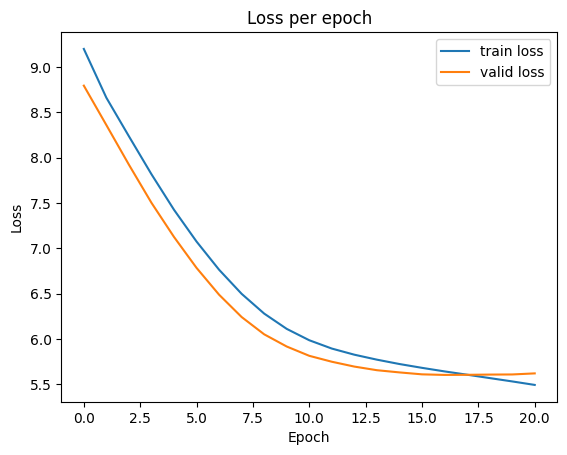

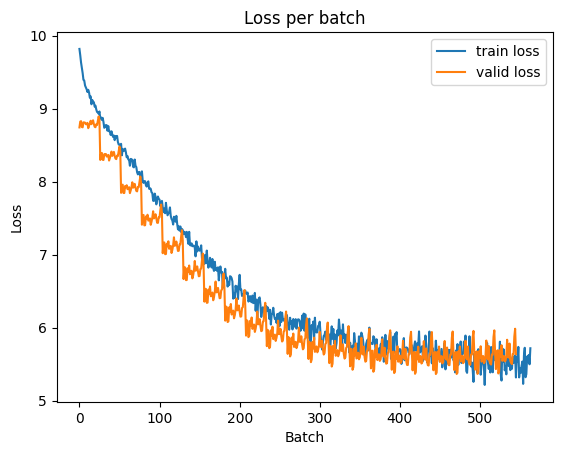

In [21]:
import torch
import torch.nn as nn
import time
import torch.nn.functional as F
from transformers import AutoTokenizer
from tqdm import tqdm
import numpy as np
from datetime import datetime, timedelta
import json
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"




def read_data(source_file, target_file):
    source_data = open(source_file).read().strip().split("\n")
    target_data = open(target_file).read().strip().split("\n")
    return source_data, target_data


def validate_epoch(model, valid_loader, epoch, n_epochs, source_pad_id, target_pad_id, device):
    model.eval()
    total_loss = []
    total_correct = 0
    total_samples = 0
    bar = tqdm(enumerate(valid_loader), total=len(valid_loader), desc=f"Validating epoch {epoch+1}/{n_epochs}")
    for i, batch in bar:
        source, target = batch["source_ids"].to(device), batch["target_ids"].to(device)
        target_input = target[:, :-1]
        source_mask, target_mask = model.make_source_mask(source, source_pad_id), model.make_target_mask(target_input)
        preds = model(source, target_input, source_mask, target_mask)
        gold = target[:, 1:].contiguous().view(-1)
        loss = F.cross_entropy(preds.view(-1, preds.size(-1)), gold, ignore_index=target_pad_id)
        total_loss.append(loss.item())
        bar.set_postfix(loss=total_loss[-1])

    valid_loss = sum(total_loss) / len(total_loss)
    return valid_loss, total_loss


def train_epoch(model, train_loader, optim, epoch, n_epochs, source_pad_id, target_pad_id, device):
    model.train()
    total_loss = []
    bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Training epoch {epoch+1}/{n_epochs}")
    total_correct = 0
    total_samples = 0

    for i, batch in bar:
        source, target = batch["source_ids"].to(device), batch["target_ids"].to(device)
        target_input = target[:, :-1]
        source_mask, target_mask = model.make_source_mask(source, source_pad_id), model.make_target_mask(target_input)
        preds = model(source, target_input, source_mask, target_mask)
        optim.zero_grad()
        gold = target[:, 1:].contiguous().view(-1)

        loss = F.cross_entropy(preds.view(-1, preds.size(-1)), gold, ignore_index=target_pad_id)
        loss.backward()
        optim.step()
        total_loss.append(loss.item())
        bar.set_postfix(loss=total_loss[-1])

    train_loss = sum(total_loss) / len(total_loss)
    return train_loss, total_loss


def train(model, train_loader, valid_loader, optim, n_epochs, source_pad_id, target_pad_id, device, model_path, early_stopping):
    log_dir = "./logs"
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)

    best_val_loss = np.Inf
    best_epoch = 1
    count_early_stop = 0
    log = {"train_loss": [], "valid_loss": [], "train_batch_loss": [], "valid_batch_loss": []}
    for epoch in range(n_epochs):
        train_loss, train_losses = train_epoch(
            model=model,
            train_loader=train_loader,
            optim=optim,
            epoch=epoch,
            n_epochs=n_epochs,
            source_pad_id=source_pad_id,
            target_pad_id=target_pad_id,
            device=device
        )
        valid_loss, valid_losses = validate_epoch(
            model=model,
            valid_loader=valid_loader,
            epoch=epoch,
            n_epochs=n_epochs,
            source_pad_id=source_pad_id,
            target_pad_id=target_pad_id,
            device=device
        )

        if valid_loss < best_val_loss:
            best_val_loss = valid_loss
            best_epoch = epoch + 1
            # save model
            torch.save(model.state_dict(), model_path)
            print("---- Detect improment and save the best model ----")
            count_early_stop = 0
        else:
            count_early_stop += 1
            if count_early_stop >= early_stopping:
                print("---- Early stopping ----")
                break

        torch.cuda.empty_cache()

        log["train_loss"].append(train_loss)
        log["valid_loss"].append(valid_loss)
        log["train_batch_loss"].extend(train_losses)
        log["valid_batch_loss"].extend(valid_losses)
        log["best_epoch"] = best_epoch
        log["best_val_loss"] = best_val_loss
        log["last_epoch"] = epoch + 1

        with open(os.path.join(log_dir, "log.json"), "w") as f:
            json.dump(log, f)

        print(f"---- Epoch {epoch+1}/{n_epochs} | Train loss: {train_loss:.4f} | Valid loss: {valid_loss:.4f} | Best Valid loss: {best_val_loss:.4f} | Best epoch: {best_epoch}")

    return log


def main():
    train_src_data, train_trg_data = read_data(configs["train_source_data"], configs["train_target_data"])
    valid_src_data, valid_trg_data = read_data(configs["valid_source_data"], configs["valid_target_data"])


    model = Transformer(
        source_vocab_size=28000,
        target_vocab_size=18000,
        embedding_dim=configs["embedding_dim"],
        source_max_seq_len=configs["source_max_seq_len"],
        target_max_seq_len=configs["target_max_seq_len"],
        num_layers=configs["n_layers"],
        num_heads=configs["n_heads"],
        dropout=configs["dropout"]
    )

    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

    optim = torch.optim.Adam(model.parameters(), lr=configs["lr"], betas=(0.9, 0.98), eps=1e-9)

    train_dataset = TrainTranslateDataset(
        source_data=train_src_data,
        target_data=train_trg_data,
        source_max_seq_len=configs["source_max_seq_len"],
        target_max_seq_len=configs["target_max_seq_len"],
    )
    valid_dataset = ValidTranslateDataset(
        source_data=valid_src_data,
        target_data=valid_trg_data,
        source_max_seq_len=configs["source_max_seq_len"],
        target_max_seq_len=configs["target_max_seq_len"],
    )

    device = torch.device(configs["device"])
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=configs["batch_size"],
        shuffle=True
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=configs["batch_size"],
        shuffle=False
    )

    model.to(configs["device"])
    train(model=model,
        train_loader=train_loader,
        valid_loader=valid_loader,
        optim=optim,
        n_epochs=configs["n_epochs"],
        source_pad_id=0,
        target_pad_id=0,
        device=device,
        model_path=configs["model_path"],
        early_stopping=configs["early_stopping"]
    )

    plot_loss(log_path="./logs/log.json", log_dir="./logs")

if __name__ == "__main__":
    main()


In [15]:
test_target_path='/content/test_2016_flickr.de'
target_tokenizer=SoMaJo("de_CMC", split_camel_case=True)


def targ_preprocess_seq(seq):
          seq = re.sub(
          r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’\!;]", " ", str(seq))
          seq = re.sub(r"[ ]+", " ", seq)
          seq = re.sub(r"\!+", "!", seq)
          seq = re.sub(r"\,+", ",", seq)
          seq = re.sub(r"\?+", "?", seq)
          seq = re.sub(r"[^\w\s]", "", seq)
          seq = re.sub(r"\d+", "",seq)
          seq = seq.lower()
          return seq

with open(test_target_path, "r") as file:
         test_target_array=[]
         for i in range(1000):
          target_line=file.readline()
          target_result=targ_preprocess_seq(target_line)
          sentences = target_tokenizer.tokenize_text([target_result])
          for sentence in sentences:
             sentence_tokens = [token.text for token in sentence]
             test_target_array.append(sentence_tokens)

         max_length=max(len(sentence) for sentence in test_target_array)
         print(max_length)

def frequency_of_vocab(data):
          flattened_list = [item for sublist in data for item in sublist]

          element_count = Counter(flattened_list)
          element_count_dict = dict(element_count)


          #words = ' '.join(data)
          #list로 변
          #words = words.split(data)

         #몇번 반복되는지 확인해주는 counter
         #counter = Counter(data)
         #print(len(counter))
         #오름차순으로 정렬
          vocab = sorted(element_count_dict, key=element_count_dict.get, reverse=True)
         #1위부터 매핑
          int2word = dict(enumerate(vocab, 1))
         #순서반대
          int2word[0] = ''
          word2int = {word: id for id, word in int2word.items()}
          print(len(word2int))
          return word2int

target_new_dict=frequency_of_vocab(test_target_array)


32
2107


In [39]:
import torch

from torchtext.data.metrics import bleu_score
import sys
import sentencepiece as spm
from somajo import SoMaJo
import re
import numpy as np
from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
smoothie = SmoothingFunction()


def preprocess_seq(seq):
          seq = re.sub(
          r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’\!;]", " ", str(seq))
          seq = re.sub(r"[ ]+", " ", seq)
          seq = re.sub(r"\!+", "!", seq)
          seq = re.sub(r"\,+", ",", seq)
          seq = re.sub(r"\?+", "?", seq)
          seq = re.sub(r"[^\w\s]", "", seq)
          seq = re.sub(r"\d+", "",seq)
          seq = re.sub(r" ", "\u2581", seq)
          seq = seq.lower()
          return seq

def targ_preprocess_seq(seq):
          seq = re.sub(
          r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’\!;]", " ", str(seq))
          seq = re.sub(r"[ ]+", " ", seq)
          seq = re.sub(r"\!+", "!", seq)
          seq = re.sub(r"\,+", ",", seq)
          seq = re.sub(r"\?+", "?", seq)
          seq = re.sub(r"[^\w\s]", "", seq)
          seq = re.sub(r"\d+", "",seq)
          seq = seq.lower()
          return seq


def pad_features(sources, pad_id, seq_length):

    features = np.full((len(sources), seq_length), pad_id, dtype=int)

    for i, row in enumerate(sources):
      features[i, :len(row)] = np.array(row)[:seq_length]
          #print(features[0])

    return features


def translate_sentence(src_sentence,trg_sentence):

    device=torch.device("cpu")

    model = Transformer(
            source_vocab_size=4000,
            target_vocab_size=2107,
            embedding_dim=configs["embedding_dim"],
            source_max_seq_len=configs["source_max_seq_len"],
            target_max_seq_len=configs["target_max_seq_len"],
            num_layers=configs["n_layers"],
            num_heads=configs["n_heads"],
            dropout=configs["dropout"]
              )
    # Convert to Tensor
    sentence_array=[]
    sentence=preprocess_seq(src_sentence)
    sentence_tokens=sp.EncodeAsPieces(sentence)
    sentence_array.append(sentence_tokens)
    sentence_enc=[[source_new_dict[value] for value in eng] for eng in sentence_array]
    sentence_features=pad_features(sentence_enc, pad_id=0, seq_length=64)
    trg_sentence=torch.LongTensor(trg_sentence).to(device)
    trg_tensor=trg_sentence.unsqueeze(0)

    src_sentence_tensor = torch.LongTensor(sentence_features).to(device)
    source_mask= model.make_source_mask(src_sentence_tensor, 0).to(device)
    encoder_output = model.encoder.forward(src_sentence_tensor, source_mask)
    target_mask = model.make_target_mask(trg_tensor).to(device)
    prediction=[]
    predicition2=[]

    #one prediction of one sentence
    for _ in range(64):
     # Decoder forward pass
     pred = model.decoder.forward(trg_tensor, encoder_output, source_mask, target_mask)
     pred = F.softmax(model.final_linear(pred), dim=-1)
     pred = pred[:, -1, :].view(-1)
     token_index = torch.argmax(pred, keepdim=True)
     prediction.append(token_index.item())
     pred_sent=[reversed[number] for number in prediction]
     sentence = ' '.join(pred_sent)
     if token_index.item()==2:
      print("EOS")
    print(sentence)
    return sentence

def frequency_of_vocab(data):
          flattened_list = [item for sublist in data for item in sublist]

          element_count = Counter(flattened_list)
          element_count_dict = dict(element_count)


          #words = ' '.join(data)
          #list로 변
          #words = words.split(data)

         #몇번 반복되는지 확인해주는 counter
         #counter = Counter(data)
         #print(len(counter))
         #오름차순으로 정렬
          vocab = sorted(element_count_dict, key=element_count_dict.get, reverse=True)
         #1위부터 매핑
          int2word = dict(enumerate(vocab, 1))
         #순서반대
          int2word[0] = '<PAD>'
          word2int = {word: id for id, word in int2word.items()}


          return word2int


#source read
test_source_path='/content/test_2016_flickr.en'
src_test_data=open(test_source_path).read()
src_test_path = "eng_test.txt"
with open(src_test_path, "w") as file:
 file.writelines(src_test_data)

# Load english tokenizer
ssource= spm.SentencePieceTrainer.train('--input=eng_test.txt  --model_prefix=wmt2016entest --vocab_size=4000 --model_type=bpe --max_sentence_length=9999')
sp = spm.SentencePieceProcessor()
sp.Load('wmt2016entest.model')

#vocab to dict
source_vocab_dict = {}
source_new_dict={}
with open("wmt2016entest.vocab", "r", encoding="utf-8") as f:
 for line in f:
        source_word, source_index = line.strip().split('\t')  # 탭 문자로 분리
        source_vocab_dict[source_word] = int(source_index)
        source_new_dict = {key:abs(value)+3 for key, value in source_vocab_dict.items()}
        source_new_dict[0] = '<PAD>'
        source_new_dict['<unk>']= 0
        source_new_dict['<s>']= 1
        source_new_dict['</s>']= 2

#target read
target_test_path='/content/test_2016_flickr.de'
target_test_data = open(target_test_path).read()
trg_testfile_path = "de_germantext_file.txt"
with open(trg_testfile_path, "w") as file1:
 file1.writelines(target_test_data)

#target tokenization
target_tokenizer=SoMaJo("de_CMC", split_camel_case=True, xml_sentences="s")
with open(trg_testfile_path, "r") as file2:
    target_test_array=[]
    for i in range(1000):
     target_test_line=file2.readline()
     target_test_result=targ_preprocess_seq(target_test_line)
     sentences = target_tokenizer.tokenize_text([target_test_result])
     for sentence in sentences:
         sentence_tokens = [token.text for token in sentence]
         target_test_array.append(sentence_tokens)

#target vocab
test_vocab=frequency_of_vocab(target_test_array)
reversed={value: key for key, value in test_vocab.items()}
#target encode
target_test_enc=[[test_vocab[value] for value in eng] for eng in tqdm(target_test_array)]
#target padding
target_test_features = pad_features(target_test_enc, pad_id=0, seq_length=64)

#source array
with open(src_test_path, "r") as file:
 source_test_array=[]
 for i in range(5):
     source_testline=file.readline()
     source_test_array.append(source_testline)

#prediction of sentences
pred_sents=[]
for source_sentence, target_sentence in tqdm(zip(source_test_array,target_test_features)):
 translated=translate_sentence(source_sentence, target_sentence)
 pred_sents.append([translated])


#prepare for target data
with open(trg_testfile_path, "r") as file4:
    target_testsentence_array=[]
    for e in range(5):
     target_test_line=file4.readline()
     target_testsentence_array.append(target_test_line)

def calculate_bleu(target, output):

    #hypotheses1 = [preprocess_seq(sent).split() for sent in output]
    #references1 = [[sent.split()] for sent in target]
    hypotheses= [sent for sent in output]
    references = [sent for sent in target]
    print(len(hypotheses))
    print(len(references))

    weights = [(0.5, 0.5),(0.333, 0.333, 0.334),(0.25, 0.25, 0.25, 0.25)]
    bleu_2 = corpus_bleu(references, hypotheses, weights=weights[0])
    bleu_3 = corpus_bleu(references, hypotheses, weights=weights[1])
    bleu_4 = corpus_bleu(references, hypotheses, weights=weights[2])
    print(f"BLEU-2: {bleu_2} | BLEU-3: {bleu_3} | BLEU-4: {bleu_4}")
    return {"bleu_2": bleu_2, "bleu_3": bleu_3, "bleu_4": bleu_4}

for targ, out in zip(target_testsentence_array, pred_sents):
 calculate_bleu(targ,out)


100%|██████████| 1000/1000 [00:00<00:00, 279062.14it/s]
1it [00:07,  7.68s/it]

ins tun stoff acker ins als brechenden stoff steinen autoreifen acker freunde statt stoff ins pitcher ins steinen ins wälzt freunde bahnstation acker steinen sex inspiziert ins stoff verknoteter autoreifen inspiziert freunde acker schafft acker kuh autoreifen autoreifen sprung steinen brechenden brechenden acker autoreifen reflektiert liest ins gekleideten autoreifen autoreifen arten dschungellandschaft steinen inspiziert ins tennisschläger brechenden gekleideten deck autoreifen brechenden deck autoreifen ins


2it [00:15,  7.69s/it]

dessen dessen salto dessen schönen perücken kinderspielzeug dessen schönen eingezäunten schönen fünf welpen dessen hund schönen schönen schönen schönen perücken liefern achtet schönen schönen dessen schnurrbart dessen schönen schönen liefern dessen schönen schönen schönen dessen schönen schönen schönen dessen schönen schönen dessen salto schönen schönen schönen schönen dessen schönen schlagzeug schönen dessen schönen schönen schönen schönen dessen dessen schönen schönen dessen schönen dessen schönen


3it [00:22,  7.37s/it]

afrikanischen afrikanischen grillt gemeinsam dschungellandschaft dschungellandschaft dschungellandschaft mauer afrikanischen afrikanischen gebetsfahnen mauer steigt weg steigt afrikanischen dschungellandschaft zwei dschungellandschaft dschungellandschaft zwei mauer afrikanischen gemeinsam dschungellandschaft gerahmter graffiti mauer dschungellandschaft dschungellandschaft dschungellandschaft gemeinsam afrikanischen grillt afrikanischen gemeinsam gatter mauer afrikanischen dschungellandschaft gemeinsam grillt dschungellandschaft dschungellandschaft mauer dschungellandschaft gesenkt dach afrikanischen grillt dschungellandschaft afrikanischen grillt dschungellandschaft mauer mauer mauer zwei afrikanischen dschungellandschaft dschungellandschaft schlagmal afrikanischen afrikanischen


4it [00:30,  7.57s/it]

übergroßer vorstadtstraße weiterer übergroßer vorstadtstraße übergroßer übergroßer einheimischer einheimischer übergroßer erwachsenen einheimischer putzt bullen jacke übergroßer übergroßer übergroßer übergroßer bäumen teppich pulswärmer übergroßer übergroßer übergroßer einheimischer übergroßer crosstrainer übergroßer vorstadtstraße blumensträuße einheimischer einheimischer jacke übergroßer übergroßer einheimischer einheimischer übergroßer einheimischer bäumen einheimischer teppich dekorierten übergroßer übergroßer übergroßer gerammt einheimischer übergroßer einheimischer teppich übergroßer dekorierten angelt jacke markt übergroßer übergroßer übergroßer übergroßer teppich verknoteter blumensträuße


5it [00:37,  7.46s/it]

gegend smaragdgrünen smaragdgrünen grill gewässer vier herbst autos zusieht grill weg sportbekleidung gegend antikes grill autos smaragdgrünen grill weg gewässer gerahmten weg personen wache weg weg feuer frische leute weg ziege weg sportbekleidung vier junges weg trinnken autos autos gewässer grill weg smaragdgrünen weg weg grill weg sportbekleidung weg weg sportbekleidung grill weg smaragdgrünen dreht gewässer frauenfußballmannschaft professionell weg weg sonne weg bearbeiten hinten
1
1
59


AssertionError: The number of hypotheses and their reference(s) should be the same 

In [36]:
lists=[]
at=[1,2]
bt=[3,4]
for a,b in zip(at, bt):
  c= a+b
  lists.append([c])
  print(lists)
print(lists)

[[4]]
[[4], [6]]
[[4], [6]]
